# 4. Simulation: Balanced Friedman1

Description:
* Using Friedman-1 dataset from sklearn.datasets: balanced dataset
* Taking samples from the dataset with preserving the proportions of the classes in both splits (training, test vs. training, test and validation) by stratification and comparing it to random splitting* visual inspection of distribution of train-test split
* visual inspection of distribution of train-test split
* fit RandomForestRegressor
* RandomizedSearchCV for hyperparameter tuning
* Stratification based on quantiles with pd.qcut

In [28]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.datasets import make_friedman1
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import random
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor


In [3]:
# Fill in the path where you downloaded the project or if the hole folder is open, leave it as it is. 
# Should print what in your folder is.
ROOT_PATH = '.'
print(os.listdir(ROOT_PATH))

['data', 'Pseudocode.ipynb', 'Simulation01_housing_visual.ipynb', 'Simulation02_housing_rf.ipynb', 'Simulation03_friedman_unbalanced.ipynb', 'Simulation04_friedman_balanced.ipynb', 'Stratificaiton.ipynb', 'utils.py', 'utils_Nadja.py', '__pycache__']


In [38]:
from utils import generate_friedman1, to_dataframe, plot_data_3D, train_test_stratified, evaluate_rf, create_cont_folds
from utils_Nadja import fold_visualizer

ImportError: cannot import name 'create_cont_folds' from 'utils' (c:\Users\anneg\Documents\Documents\StatistikMaster\slds_stratification\Simulations\utils.py)

## Generate Friedman1 dataset

In [5]:
features, y = generate_friedman1(n_samples=1000)
(features, y)

(array([[0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864],
        [0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258],
        [0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497],
        ...,
        [0.1531445 , 0.72811644, 0.60025141, 0.73125059, 0.76974662],
        [0.97541037, 0.57356328, 0.34164111, 0.64846456, 0.06844071],
        [0.89739732, 0.11938101, 0.32784284, 0.81574538, 0.59731238]]),
 array([16.83826156, 12.51782504,  5.86968919,  7.53187897,  9.45737165,
        10.88906915, 21.29818121, 19.26769898, 16.61008184, 12.44163815,
        22.83735821,  6.46236702, 10.38662987,  9.88601081, 21.21547558,
        17.60207288, 12.69134012, 18.39401421, 13.47560394,  8.14785175,
        10.94077686,  7.1379749 , 16.40332854, 21.67042684, 10.53641573,
        14.12700131, 13.85231999, 14.34693947, 11.33172011,  2.61396215,
        18.66039324, 12.27788144, 12.83883023, 12.78596049,  5.84676689,
        14.00663761, 14.88326076, 16.4903815 , 13.8271

In [6]:
df=to_dataframe(features=features, y=y)
df

,X1,X2,X3,X4,X5,y
0,0.374540,0.950714,0.731994,0.598658,0.156019,16.838262
1,0.155995,0.058084,0.866176,0.601115,0.708073,12.517825
2,0.020584,0.969910,0.832443,0.212339,0.181825,5.869689
3,0.183405,0.304242,0.524756,0.431945,0.291229,7.531879
4,0.611853,0.139494,0.292145,0.366362,0.456070,9.457372
...,...,...,...,...,...,...
995,0.446726,0.123450,0.205980,0.000943,0.039265,3.658595
996,0.977284,0.242354,0.663311,0.839100,0.550660,18.450667
997,0.153145,0.728116,0.600251,0.731251,0.769747,14.794133
998,0.975410,0.573563,0.341641,0.648465,0.068441,17.154440


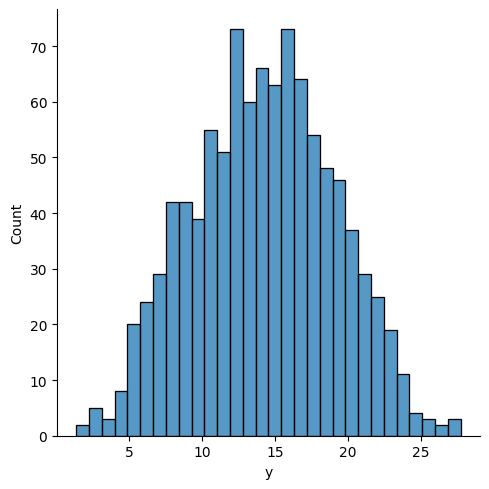

In [164]:
sns.displot(df, x='y', bins = 30)

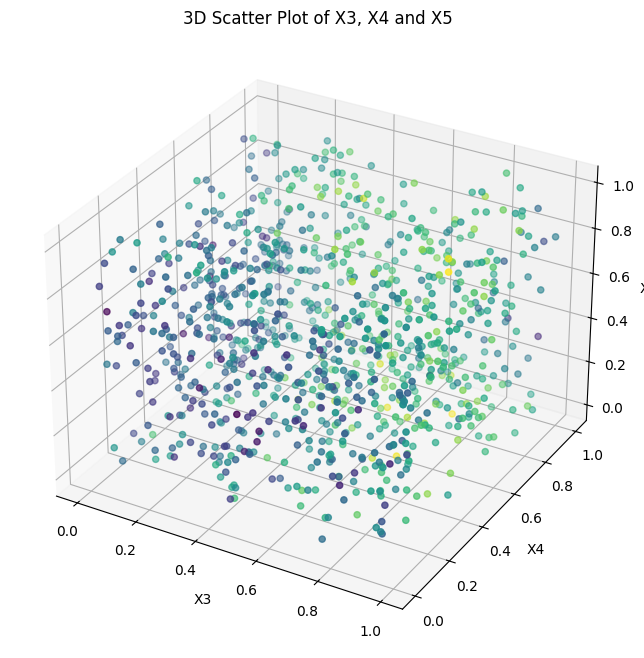

In [165]:
plot_data_3D(df, ['X3', 'X4','X5'])

### What if we add noise??

In [68]:
features_noise, y_noise = generate_friedman1(noise=10)
df_noise=to_dataframe(features_noise, y_noise)
df_noise

,X1,X2,X3,X4,X5,y
0,0.374540,0.950714,0.731994,0.598658,0.156019,16.647628
1,0.155995,0.058084,0.866176,0.601115,0.708073,24.590708
2,0.020584,0.969910,0.832443,0.212339,0.181825,12.122614
3,0.183405,0.304242,0.524756,0.431945,0.291229,-0.515011
4,0.611853,0.139494,0.292145,0.366362,0.456070,27.328506
...,...,...,...,...,...,...
9995,0.532481,0.550056,0.984144,0.599966,0.666627,28.648759
9996,0.213723,0.106865,0.602010,0.864880,0.587373,8.005824
9997,0.442783,0.578207,0.468772,0.141882,0.741184,29.699039
9998,0.533038,0.399323,0.559639,0.241227,0.427958,-1.211299


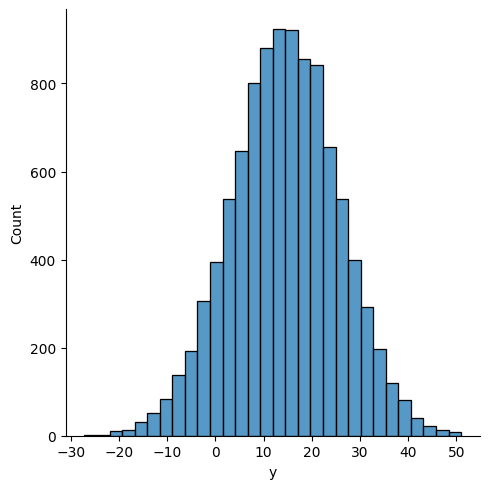

In [69]:
sns.displot(df_noise, x='y', bins = 30)

-> It doesn't really make it imbalanced, but standard deviation becomes larger.

## Random Forest without stratification

In [25]:
# first devide data in train/test data (80/20 ratio)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[: , :-1], 
                                                    df['y'], 
                                                    test_size=0.2, 
                                                    random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 5) (200, 5) (800,) (200,)


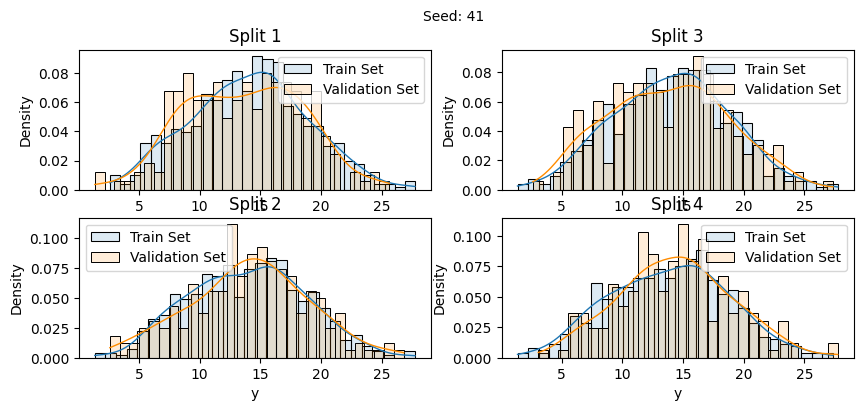

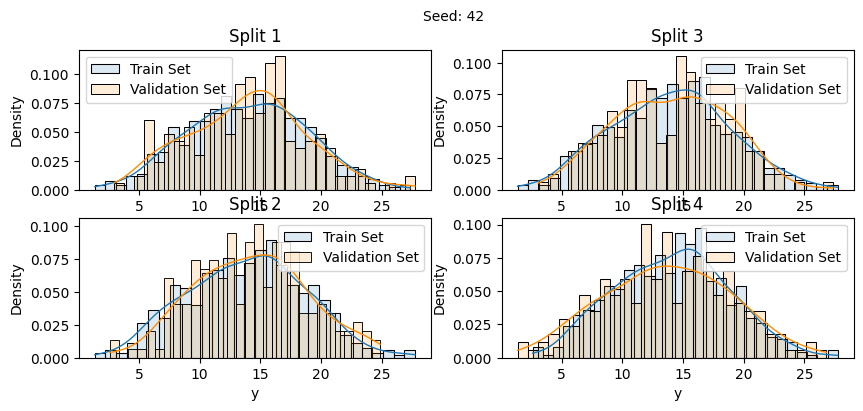

In [171]:
labels = y_train.reset_index(drop=True)


for i in [41, 42]:
    baseline_kfold = list(KFold(4,
                                shuffle=True,
                                random_state=i
                               ).split(labels))
    fold_visualizer(data=labels,
                    fold_idxs=baseline_kfold,
                    seed_num=i)

In [167]:
# Define the parameter grid for random search
param_rf = {
    'n_estimators': np.arange(500, 1001),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, X_train.shape[1] + 1)
}

In [168]:
# Initialize Random Forest model
rf_model=RandomForestRegressor(random_state=42)
                            

In [169]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, 
                                   param_distributions=param_rf,
                                   n_iter=10, 
                                   cv=5, 
                                   scoring='neg_mean_squared_error', 
                                   random_state=42)


In [170]:
# Perform the random search on the training set
random_search.fit(X_train, y_train)

# Display the best parameters found by random search
print("Best Parameters:", random_search.best_params_)


Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}


In [75]:
# Display the cross-validated score with the best parameters
best_score = random_search.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score:.4f}")



Best Cross-Validated Mean Squared Error: -3.8212


In [174]:
# Evaluate the model
score=evaluate_rf(random_search, 
                  X_train, 
                  X_test, 
                  y_train, 
                  y_test)
score

Train Set R^2 Score: 0.9116 
Test Set R^2 Score: 0.8713 
 Train Set MSE Score: 2.0160 
Test Set MSE Score: 3.1044


{'train r2': 0.9116441254490691,
 'test r2': 0.8713349562553522,
 'train mse': 2.016015131481109,
 'test mse': 3.104442938711747}

## Random Forest with Stratification

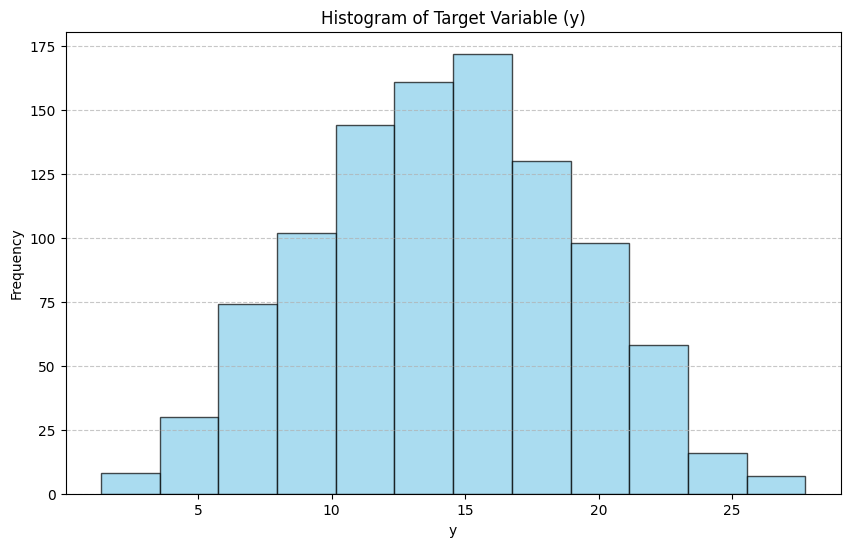

In [175]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['y'], bins='doane', color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Target Variable (y)')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

Approach with quantiles. In this case with 20 5% quantiles to sample randomly 80% from each one. 

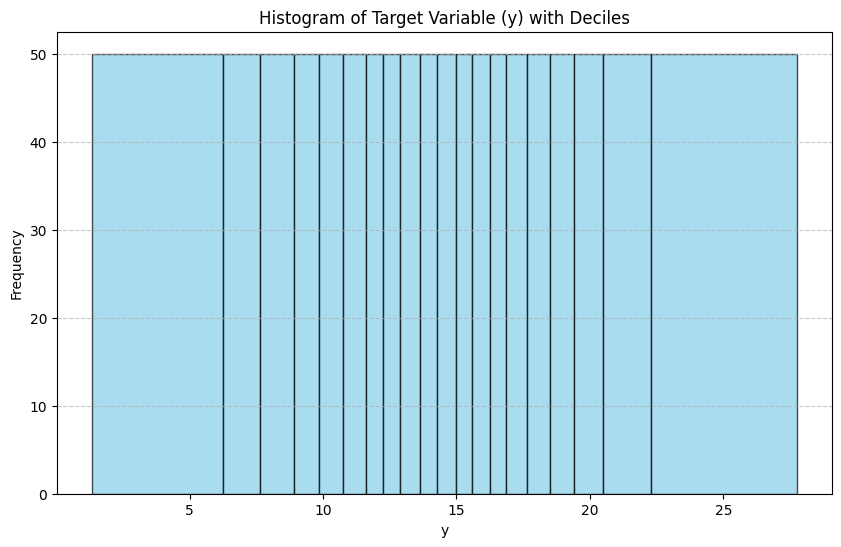

In [176]:
# Calculate decile values
quantiles = [np.percentile(df['y'], i) for i in range(0, 101, 5)]

# Plot the histogram with decile values
plt.figure(figsize=(10, 6))
plt.hist(df['y'], bins=quantiles, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Target Variable (y) with Deciles')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [44]:
from utils import train_test_stratified

In [8]:
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_stratified(df=df)

In [9]:
# Verify the sizes of the train and test sets
print("Train set size:", X_train_strat.shape, y_train_strat.shape)
print("Test set size:", X_test_strat.shape, y_test_strat.shape)

Train set size: (800, 5) (800,)
Test set size: (200, 5) (200,)


In [12]:
# Initialize Random Forest model
rf_model_strat=RandomForestRegressor(random_state=42)
# Define the parameter grid for random search
param_rf_strat = {
    'n_estimators': np.arange(500, 1001),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, X_train_strat.shape[1] + 1)
}
# Initialize RandomizedSearchCV
random_search_strat = RandomizedSearchCV(estimator=rf_model_strat, 
                                        param_distributions=param_rf_strat,
                                        n_iter=10, 
                                        cv=5, 
                                        scoring='neg_mean_squared_error', 
                                        random_state=42)

In [13]:
# Perform the random search on the training set
random_search_strat.fit(X_train_strat, y_train_strat)

# Display the best parameters found by random search
print("Best Parameters:", random_search_strat.best_params_)

Best Parameters: {'n_estimators': 661, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 2}


In [15]:
# Display the cross-validated score with the best parameters
best_score_strat = random_search_strat.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score_strat:.4f}")


Best Cross-Validated Mean Squared Error: -3.8018


In [16]:
# Evaluate the model with the best parameters on the test set
score_strat=evaluate_rf(random_search_strat, 
                        X_train_strat, 
                        X_test_strat, 
                        y_train_strat, 
                        y_test_strat)
score_strat

{'train r2': 0.9070592846589218,
 'test r2': 0.8705366608054554,
 'train mse': 2.1870573099145236,
 'test mse': 2.9233759263740215}

Metrics from training without stratification: 

* 'train r2': 0.9116,
* 'test r2': 0.8713,
* 'train mse': 2.0160,
* 'test mse': 3.1044

## Try without cross validation

In [24]:
rf_baseline=RandomForestRegressor(n_estimators=882, min_samples_split=14, min_samples_leaf=8, max_features=4, random_state=42)

In [26]:
rf_baseline.fit(X_train, y_train)

RandomForestRegressor(max_features=4, min_samples_leaf=8, min_samples_split=14,
                      n_estimators=882, random_state=42)

In [27]:
# Evaluate the model with the best parameters on the test set
train_score_base=rf_baseline.score(X_train, y_train)
test_score_base= rf_baseline.score(X_test, y_test)
print(f"Train Set R^2 Score: {train_score_base:.4f} \nTest Set R^2 Score: {test_score_base:.4f}")

Train Set R^2 Score: 0.9116 
Test Set R^2 Score: 0.8713


In [21]:
rf_baseline_strat=RandomForestRegressor(n_estimators=882, min_samples_split=14, min_samples_leaf=8, max_features=4, random_state=42)

In [22]:
rf_baseline_strat.fit(X_train_strat, y_train_strat)

RandomForestRegressor(max_features=4, min_samples_leaf=8, min_samples_split=14,
                      n_estimators=882, random_state=42)

In [23]:
# Evaluate the model with the best parameters on the test set
train_score_base_strat=rf_baseline_strat.score(X_train_strat, y_train_strat)
test_score_base_strat = rf_baseline_strat.score(X_test_strat, y_test_strat)
print(f"Train Set R^2 Score: {train_score_base_strat:.4f} \nTest Set R^2 Score: {test_score_base_strat:.4f}")

Train Set R^2 Score: 0.9122 
Test Set R^2 Score: 0.8678


# Include stratification also in cross-validation

In [39]:
X_train_stratified, X_test_stratified, y_train_stratified, y_test_stratified = train_test_stratified(df=df)

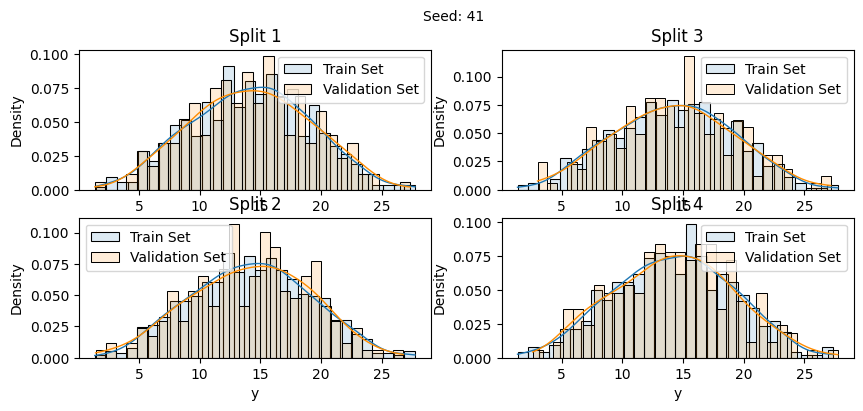

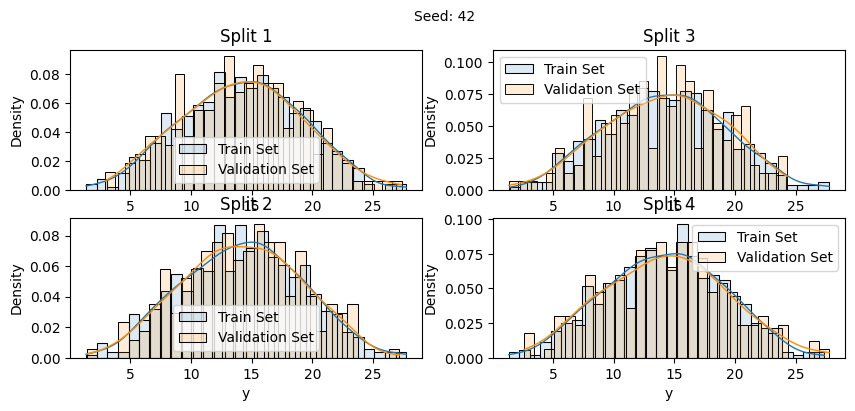

In [41]:
num_of_folds = 4
num_of_groups = 10
labels = y_train_stratified.reset_index(drop=True)

for i in [41, 42]:
    cv_splits = create_cont_folds(labels, 
                                  n_folds=num_of_folds, 
                                  n_groups=num_of_groups, 
                                  seed=i)
    fold_visualizer(data=labels,
                    fold_idxs=cv_splits,
                    seed_num=i)

In [42]:
n_folds=5
n_groups=20
# take the same training test data as before in stratification for trining/test
labels = y_train_stratified 

#cv splits
cv_splits_training = create_cont_folds(labels, 
                                       n_folds=n_folds, 
                                       n_groups=n_groups, 
                                       seed=42)

# Initialize Random Forest model
rf_model_stratified=RandomForestRegressor(random_state=42)

param_rf_stratified = {
    'n_estimators': np.arange(500, 1001),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, X_train.shape[1] + 1)
}
# Initialize RandomizedSearchCV
random_search_stratified = RandomizedSearchCV(estimator=rf_model_stratified, 
                                            param_distributions=param_rf_stratified,
                                            n_iter=10, 
                                            cv = cv_splits_training, 
                                            scoring='neg_mean_squared_error', 
                                            random_state=42)

In [43]:
# check that cv splits worked correctly
test_dat=[]
for index, value in enumerate(cv_splits_training):
    test_dat.extend(value[1])
num_unique_numbers = len(set(test_dat))
print(f"Number of unique numbers: {num_unique_numbers}")

Number of unique numbers: 800


In [44]:
# Perform the random search on the training set
random_search_stratified.fit(X_train_stratified, y_train_stratified) 

# Display the best parameters found by random search
print("Best Parameters:", random_search_stratified.best_params_)

# Display the cross-validated score with the best parameters
best_score_stratified = random_search_stratified.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score_stratified:.4f}")

Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}

Best Cross-Validated Mean Squared Error: -3.8261


In [45]:
score_stratified=evaluate_rf(random_search_stratified, 
                             X_train_stratified, 
                             X_test_stratified, 
                             y_train_stratified, 
                             y_test_stratified)

In [46]:
score_stratified

{'train r2': 0.9119102877093983,
 'test r2': 0.8676145143987252,
 'train mse': 2.072904738105417,
 'test mse': 2.9893601077795298}

In [35]:
score_strat

{'train r2': 0.9070592846589218,
 'test r2': 0.8705366608054554,
 'train mse': 2.1870573099145236,
 'test mse': 2.9233759263740215}